# Adaboost frim scratch

In [40]:
import numpy as np
from sklearn.tree import DecisionTreeClassifier

In [41]:
import warnings
warnings.filterwarnings('error', category=RuntimeWarning)

In [42]:
# accuracy computation
# this data is not highly imbalanced so accuracy is ok
def accuracy(y, pred):
    return np.sum(y == pred) / float(len(y)) 

In [43]:
def parse_spambase_data(filename):
    """ Given a filename return X and Y numpy arrays

    X is of size number of rows x num_features
    Y is an array of size the number of rows
    Y is the last element of each row. (Convert 0 to -1)
    """
    with open(filename) as t:
        mat = t.readlines()
    mat = [l.rstrip() for l in mat]
    mat= np.array([list(map(float,m.split(','))) for i,m in enumerate(mat)])
    X = mat[:,0:-1]
    Y = mat[:,-1]
    Y[Y == 0] = -1.0
    
    return X, Y

In [44]:
y_test = np.array([1., -1., 1., 1., -1., -1., 1., 1., 1., -1.])
X, Y = parse_spambase_data("tiny.spam.train")
for i in range(len(y_test)): assert(y_test[i] == Y[i])
n, m = X.shape
assert(n == 10)
assert(m == 57)

In [45]:
def adaboost(X, y, num_iter, max_depth=1):
    """Given an numpy matrix X, a array y and num_iter return trees and weights 
   
    Input: X, y, num_iter
    Outputs: array of trees from DecisionTreeClassifier
             trees_weights array of floats
    Assumes y is {-1, 1}
    """
    trees = []
    trees_weights = [] 
    N, _ = X.shape
    d = np.ones(N) / N
    
    for i in range(num_iter):
        max_depth = 1
        h= DecisionTreeClassifier(max_depth=max_depth, random_state=0)
        h.fit(X, y, sample_weight=d)
        trees.append(h)
        pred = h.predict(X)
        err = np.sum(d[y != pred])/np.sum(d)
#         print(y, pred, err,d[y != pred], np.sum(d) )
        if err != 0.0:
            alpha = np.log((1-err)/err)
            trees_weights.append(alpha)
            d[y != pred] = d[y != pred]*np.exp(alpha)
        else:
            alpha = 1
            trees_weights.append(alpha)
            
    return trees, trees_weights

In [46]:
X, Y = parse_spambase_data("tiny.spam.train")
trees, weights = adaboost(X, Y, 2)
y_hat_0 = trees[0].predict(X)
assert(len(trees) == 2)
assert(len(weights) == 2)
assert(isinstance(trees[0], DecisionTreeClassifier))
assert(np.array_equal(y_hat_0[:5], [1.,-1.,1, 1, -1]))

In [47]:
y_hat_0 = trees[0].predict(X)
assert(np.array_equal(y_hat_0[:5], [1.,-1.,1, 1, -1]))

In [48]:
def adaboost_predict(X, trees, trees_weights):
    """Given X, trees and weights predict Y
    """
    # X input, y output
    N, _ =  X.shape
    y = np.zeros(N)
    
    for t,w in zip(trees, trees_weights):
        y += w*t.predict(X)
        
    y[y>=0] = 1
    y[y<0] = -1
    
    return y

In [49]:
x = np.array([[0, -1], [1, 0], [-1, 0]])
y = np.array([-1, 1, 1])
trees, weights = adaboost(x, y, 1)
pred = adaboost_predict(x, trees, weights)
assert(np.array_equal(pred, y))

In [50]:
X, Y = parse_spambase_data("spambase.train")
X_test, Y_test = parse_spambase_data("spambase.test")
trees, trees_weights = adaboost(X, Y, 10)
Yhat = adaboost_predict(X, trees, trees_weights)
Yhat_test = adaboost_predict(X_test, trees, trees_weights)
    
acc_test = accuracy(Y_test, Yhat_test)
acc_train = accuracy(Y, Yhat)
print("Train Accuracy %.4f" % acc_train)
print("Test Accuracy %.4f" % acc_test)
assert(np.around(acc_train, decimals=4)==0.9111)
assert(np.around(acc_test, decimals=4)==0.9190)

Train Accuracy 0.9111
Test Accuracy 0.9190


# Gradient boosting for regression with MSE loss

In [51]:
def load_dataset():
    dataset = np.loadtxt("rent-ideal.csv", delimiter=",", skiprows=1)
    y = dataset[:, -1]
    X = dataset[:, 0:- 1]
    return X, y

In [52]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split


def gradient_boosting_mse(X, y, num_iter, max_depth=1, nu=0.1):
    """Given X, a array y and num_iter return y_mean and trees 
   
    Input: X, y, num_iter
           max_depth
           nu (is the shinkage)
    Outputs:y_mean, array of trees from DecisionTreeRegression
    """
    trees = []
    N, _ = X.shape
    y_mean = np.mean(y)
    fm = y_mean
    
    for i in range(num_iter):
        r = y - fm
        T = DecisionTreeRegressor(max_depth=max_depth, random_state=0)
        T.fit(X,r)
        preds = T.predict(X)*nu
        fm = fm + preds
        trees.append(T)

    return y_mean, trees   

In [53]:
X, y = load_dataset()
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, random_state=3)

y_mean, trees = gradient_boosting_mse(X_train, y_train, 300, max_depth=7, nu=0.1)


In [54]:
assert(np.around(y_mean, decimals=4)==3434.7185)

In [55]:
def gradient_boosting_predict(X, trees, y_mean,  nu=0.1):
    """Given X, trees, y_mean predict y_hat
    """
    y_hat = y_mean
    for t in trees:
        y_hat += t.predict(X)*nu

    return y_hat

In [56]:
X, y = load_dataset()
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, random_state=3)

y_mean, trees = gradient_boosting_mse(X_train, y_train, 300, max_depth=7, nu=0.1)
assert(np.around(y_mean, decimals=4)==3434.7185)
y_hat_train = gradient_boosting_predict(X_train, trees, y_mean, nu=0.1)
assert(np.around(r2_score(y_train, y_hat_train), decimals=4)== 0.8993) 

In [57]:
y_hat = gradient_boosting_predict(X_val, trees, y_mean, nu=0.1)
assert(np.around(r2_score(y_val, y_hat), decimals=4)== 0.8399)

## (b) Plot num_trees vs $R^2$

In [9]:
import time
X, y = load_dataset()
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, random_state=3)
r2_t = []
r2_v = []

for i in range(200,2500,100):
    start = time.time()
    y_mean, trees = gradient_boosting_mse(X_train, y_train, i , max_depth=7, nu=0.1)
    y_hat_train = gradient_boosting_predict(X_train, trees, y_mean, nu=0.1)
    r2_t.append(np.around(r2_score(y_train, y_hat_train), decimals=4))
    y_hat = gradient_boosting_predict(X_val, trees, y_mean, nu=0.1)
    r2_v.append(np.around(r2_score(y_val, y_hat), decimals=4))
    end = time.time()
    
    print(f'Process for {i} finished in %d secs' % round((end - start),4)) 

Process for 200 finished in 5 secs
Process for 300 finished in 7 secs
Process for 400 finished in 10 secs
Process for 500 finished in 12 secs
Process for 600 finished in 15 secs
Process for 700 finished in 18 secs
Process for 800 finished in 20 secs
Process for 900 finished in 23 secs
Process for 1000 finished in 26 secs
Process for 1100 finished in 29 secs
Process for 1200 finished in 31 secs
Process for 1300 finished in 34 secs
Process for 1400 finished in 35 secs
Process for 1500 finished in 37 secs
Process for 1600 finished in 40 secs
Process for 1700 finished in 42 secs
Process for 1800 finished in 45 secs
Process for 1900 finished in 47 secs
Process for 2000 finished in 50 secs
Process for 2100 finished in 52 secs
Process for 2200 finished in 55 secs
Process for 2300 finished in 57 secs
Process for 2400 finished in 61 secs


The validation $R^2$ increases and plateaus above 1000. A good choice for num_trees could be between 1000-1500 since there isnt much of difference in $R^2$

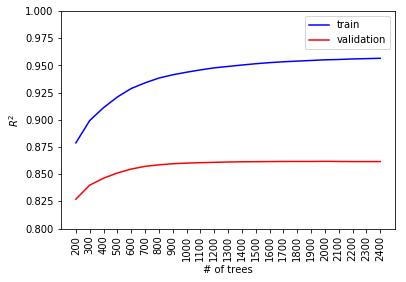

In [29]:
import matplotlib.pyplot as plt
% matplotlib inline
x = list(range(200,2500,100))
train, = plt.plot(x, r2_t, c = 'b', label = 'train')
val, = plt.plot(x, r2_v, c = 'r', label = 'validation')
plt.legend(handles=[train, val])


plt.xticks( x, rotation = 90)
plt.xlabel('# of trees')
plt.ylabel('$R^2$')
plt.legend()
plt.ylim(0.8,1.)
plt.show()

In [23]:
{k:v for k,v in zip(x,r2_v)}

{200: 0.827,
 300: 0.8399,
 400: 0.8463,
 500: 0.8511,
 600: 0.8547,
 700: 0.8572,
 800: 0.8586,
 900: 0.8596,
 1000: 0.8602,
 1100: 0.8606,
 1200: 0.8609,
 1300: 0.8612,
 1400: 0.8614,
 1500: 0.8615,
 1600: 0.8616,
 1700: 0.8617,
 1800: 0.8617,
 1900: 0.8617,
 2000: 0.8618,
 2100: 0.8617,
 2200: 0.8616,
 2300: 0.8616,
 2400: 0.8616}

## (c) Change shrinkage

**Observations:**
    
>* Xgboost trains much faster than Gradient boosting
* However , the $R_2$ for same number of iterations is lower than Xgboost.
* This could be because of the subsampling of data

In [66]:
import time
X, y = load_dataset()
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, random_state=3)
r2_t = []
r2_v = []

for i in range(200,2500,100):
    start = time.time()
    xgbr = xgb.XGBRegressor(n_estimators= i , learning_rate=0.1, subsample=0.5, nthread=-1, silent =1, random_state=0)
    xgbr.fit(X_train,y_train)
    y_hat_train = xgbr.predict(X_train)
    y_hat_val = xgbr.predict(X_val)
    r2_t.append(np.around(r2_score(y_train, y_hat_train), decimals=4))
    r2_v.append(np.around(r2_score(y_val, y_hat_val), decimals=4))

    end = time.time()
    
    print(f'Process for {i} finished in %d secs' % round((end - start),4))

Process for 200 finished in 1 secs
Process for 300 finished in 1 secs
Process for 400 finished in 2 secs
Process for 500 finished in 3 secs
Process for 600 finished in 3 secs
Process for 700 finished in 4 secs
Process for 800 finished in 5 secs
Process for 900 finished in 6 secs
Process for 1000 finished in 6 secs
Process for 1100 finished in 7 secs
Process for 1200 finished in 7 secs
Process for 1300 finished in 8 secs
Process for 1400 finished in 9 secs
Process for 1500 finished in 10 secs
Process for 1600 finished in 11 secs
Process for 1700 finished in 11 secs
Process for 1800 finished in 12 secs
Process for 1900 finished in 12 secs
Process for 2000 finished in 13 secs
Process for 2100 finished in 14 secs
Process for 2200 finished in 14 secs
Process for 2300 finished in 15 secs
Process for 2400 finished in 16 secs


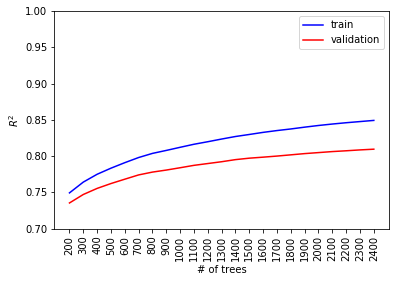

In [67]:
import matplotlib.pyplot as plt
% matplotlib inline
x = list(range(200,2500,100))
train, = plt.plot(x, r2_t, c = 'b', label = 'train')
val, = plt.plot(x, r2_v, c = 'r', label = 'validation')
plt.legend(handles=[train, val])


plt.xticks( x, rotation = 90)
plt.xlabel('# of trees')
plt.ylabel('$R^2$')
plt.legend()
plt.ylim(0.7,1.)
plt.show()

In [69]:
{k:v for k,v in zip(x,r2_v)}

{200: 0.7353,
 300: 0.747,
 400: 0.7554,
 500: 0.7621,
 600: 0.7681,
 700: 0.774,
 800: 0.7779,
 900: 0.7807,
 1000: 0.7839,
 1100: 0.7872,
 1200: 0.7897,
 1300: 0.7922,
 1400: 0.7951,
 1500: 0.7971,
 1600: 0.7985,
 1700: 0.8,
 1800: 0.8017,
 1900: 0.8034,
 2000: 0.8048,
 2100: 0.8062,
 2200: 0.8073,
 2300: 0.8085,
 2400: 0.8095}

>* The $R^2$ seems to be increasing, lets increase the number of trees and see the pattern

In [70]:
for i in range(2500,3500,100):
    start = time.time()
    xgbr = xgb.XGBRegressor(n_estimators= i , learning_rate=0.1, subsample=0.5, nthread=-1, silent =1, random_state=0)
    xgbr.fit(X_train,y_train)
    y_hat_train = xgbr.predict(X_train)
    y_hat_val = xgbr.predict(X_val)
    r2_t.append(np.around(r2_score(y_train, y_hat_train), decimals=4))
    r2_v.append(np.around(r2_score(y_val, y_hat_val), decimals=4))

    end = time.time()
    
    print(f'Process for {i} finished in %d secs' % round((end - start),4))

Process for 2500 finished in 17 secs
Process for 2600 finished in 16 secs
Process for 2700 finished in 17 secs
Process for 2800 finished in 18 secs
Process for 2900 finished in 19 secs
Process for 3000 finished in 20 secs
Process for 3100 finished in 20 secs
Process for 3200 finished in 21 secs
Process for 3300 finished in 22 secs
Process for 3400 finished in 21 secs


* $R^2$ finall seems to be plateauing, we will stop the iteration here

(0.7, 1.0)

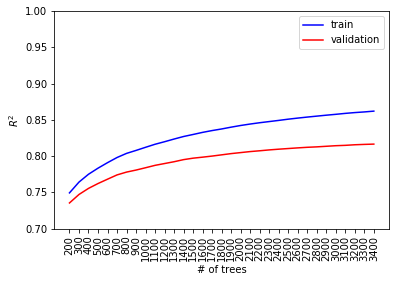

In [71]:
x = list(range(200,3500,100))
train, = plt.plot(x, r2_t, c = 'b', label = 'train')
val, = plt.plot(x, r2_v, c = 'r', label = 'validation')
plt.legend(handles=[train, val])

plt.xticks( x, rotation = 90)
plt.xlabel('# of trees')
plt.ylabel('$R^2$')
plt.legend()
plt.ylim(0.7,1. )

Num Iteration vs R2

In [72]:
{k:v for k,v in zip(x,r2_v)}

{200: 0.7353,
 300: 0.747,
 400: 0.7554,
 500: 0.7621,
 600: 0.7681,
 700: 0.774,
 800: 0.7779,
 900: 0.7807,
 1000: 0.7839,
 1100: 0.7872,
 1200: 0.7897,
 1300: 0.7922,
 1400: 0.7951,
 1500: 0.7971,
 1600: 0.7985,
 1700: 0.8,
 1800: 0.8017,
 1900: 0.8034,
 2000: 0.8048,
 2100: 0.8062,
 2200: 0.8073,
 2300: 0.8085,
 2400: 0.8095,
 2500: 0.8104,
 2600: 0.8113,
 2700: 0.8121,
 2800: 0.8127,
 2900: 0.8135,
 3000: 0.8143,
 3100: 0.8148,
 3200: 0.8156,
 3300: 0.8161,
 3400: 0.8165}

> *Since the $R^2$ is increasing in a slower pace, lets increase the learning rate to 0.4 and see how the metric varies

In [78]:
X, y = load_dataset()
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, random_state=3)
r2_t_lr3 = []
r2_v_lr3 = []

for i in range(200,2500,100):
    start = time.time()
    xgbr = xgb.XGBRegressor(n_estimators= i , learning_rate=0.4, subsample=0.5, nthread=-1, silent =1, random_state=0)
    xgbr.fit(X_train,y_train)
    y_hat_train = xgbr.predict(X_train)
    y_hat_val = xgbr.predict(X_val)
    r2_t_lr3.append(np.around(r2_score(y_train, y_hat_train), decimals=4))
    r2_v_lr3.append(np.around(r2_score(y_val, y_hat_val), decimals=4))

    end = time.time()
    
    print(f'Process for {i} finished in %d secs' % round((end - start),4))

Process for 200 finished in 1 secs
Process for 300 finished in 1 secs
Process for 400 finished in 2 secs
Process for 500 finished in 3 secs
Process for 600 finished in 3 secs
Process for 700 finished in 4 secs
Process for 800 finished in 4 secs
Process for 900 finished in 5 secs
Process for 1000 finished in 6 secs
Process for 1100 finished in 6 secs
Process for 1200 finished in 7 secs
Process for 1300 finished in 8 secs
Process for 1400 finished in 8 secs
Process for 1500 finished in 9 secs
Process for 1600 finished in 10 secs
Process for 1700 finished in 10 secs
Process for 1800 finished in 11 secs
Process for 1900 finished in 11 secs
Process for 2000 finished in 12 secs
Process for 2100 finished in 13 secs
Process for 2200 finished in 13 secs
Process for 2300 finished in 14 secs
Process for 2400 finished in 15 secs


Num Iteration vs R2

In [83]:
{k:v for k,v in zip(x,r2_v_lr3)}

{200: 0.7743,
 300: 0.784,
 400: 0.7936,
 500: 0.7995,
 600: 0.8041,
 700: 0.807,
 800: 0.8092,
 900: 0.8115,
 1000: 0.8144,
 1100: 0.8161,
 1200: 0.817,
 1300: 0.8182,
 1400: 0.8193,
 1500: 0.8213,
 1600: 0.8216,
 1700: 0.8224,
 1800: 0.8219,
 1900: 0.8237,
 2000: 0.8245,
 2100: 0.8244,
 2200: 0.824,
 2300: 0.8247,
 2400: 0.8252}

Learning rate of 0.7 seems to give $R_2$ lower than 0.4. Our optimal learning rate should be between 0.4 and 0.7

In [ ]:
X, y = load_dataset()
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, random_state=3)
r2_t_lr8 = []
r2_v_lr8 = []

for i in range(200,2500,100):
    start = time.time()
    xgbr = xgb.XGBRegressor(n_estimators= i , learning_rate=0.7, subsample=0.5, nthread=-1, silent =1, random_state=0)
    xgbr.fit(X_train,y_train)
    y_hat_train = xgbr.predict(X_train)
    y_hat_val = xgbr.predict(X_val)
    r2_t_lr8.append(np.around(r2_score(y_train, y_hat_train), decimals=4))
    r2_v_lr8.append(np.around(r2_score(y_val, y_hat_val), decimals=4))

    end = time.time()
    
    print(f'Process for {i} finished in %d secs' % round((end - start),4))

Process for 200 finished in 1 secs
Process for 300 finished in 1 secs
Process for 400 finished in 2 secs
Process for 500 finished in 3 secs
Process for 600 finished in 4 secs
Process for 700 finished in 4 secs
Process for 800 finished in 5 secs
Process for 900 finished in 5 secs
Process for 1000 finished in 6 secs
Process for 1100 finished in 7 secs
Process for 1200 finished in 7 secs
Process for 1300 finished in 9 secs
Process for 1400 finished in 9 secs
Process for 1500 finished in 9 secs
Process for 1600 finished in 10 secs
Process for 1700 finished in 11 secs


In [87]:
{k:v for k,v in zip(x,r2_v_lr8)}

{200: 0.7758,
 300: 0.7831,
 400: 0.7882,
 500: 0.7947,
 600: 0.7968,
 700: 0.799,
 800: 0.8004,
 900: 0.8029,
 1000: 0.8044,
 1100: 0.8038,
 1200: 0.8042,
 1300: 0.805,
 1400: 0.8073,
 1500: 0.8066,
 1600: 0.8053,
 1700: 0.8064,
 1800: 0.807,
 1900: 0.8053,
 2000: 0.8081,
 2100: 0.8085,
 2200: 0.8067,
 2300: 0.807,
 2400: 0.8085}

## Change number of children

> Observations:
* As we increase the min_child_weight the $R_2$ decreases.
* Also, the distance between train and validation plot decreases with increase in min_child_weight
* The feature seems to reduce variance with increase in value, giving regularization 

In [64]:
X, y = load_dataset()
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, random_state=3)
r2_t_lr8 = []
r2_v_lr8 = []

for i in range(200,2000,100):
    start = time.time()
    xgbr = xgb.XGBRegressor(n_estimators= i , learning_rate=0.1, subsample=0.5, nthread=-1, silent =1, random_state=0, min_child_weight = 5)
    xgbr.fit(X_train,y_train)
    y_hat_train = xgbr.predict(X_train)
    y_hat_val = xgbr.predict(X_val)
    r2_t_lr8.append(np.around(r2_score(y_train, y_hat_train), decimals=4))
    r2_v_lr8.append(np.around(r2_score(y_val, y_hat_val), decimals=4))

    end = time.time()
    
    print(f'Process for {i} finished in %d secs' % round((end - start),4))

Process for 200 finished in 0 secs
Process for 300 finished in 1 secs
Process for 400 finished in 1 secs
Process for 500 finished in 1 secs
Process for 600 finished in 2 secs
Process for 700 finished in 2 secs
Process for 800 finished in 2 secs
Process for 900 finished in 2 secs
Process for 1000 finished in 3 secs
Process for 1100 finished in 3 secs
Process for 1200 finished in 4 secs
Process for 1300 finished in 4 secs
Process for 1400 finished in 5 secs
Process for 1500 finished in 5 secs
Process for 1600 finished in 5 secs
Process for 1700 finished in 6 secs
Process for 1800 finished in 6 secs
Process for 1900 finished in 7 secs


In [76]:
X, y = load_dataset()
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, random_state=3)
r2_t_lr4 = []
r2_v_lr4 = []

for i in range(200,2000,100):
    start = time.time()
    xgbr = xgb.XGBRegressor(n_estimators= i , learning_rate=0.1, subsample=0.5, nthread=-1, silent =1, random_state=0, min_child_weight = 15)
    xgbr.fit(X_train,y_train)
    y_hat_train = xgbr.predict(X_train)
    y_hat_val = xgbr.predict(X_val)
    r2_t_lr4.append(np.around(r2_score(y_train, y_hat_train), decimals=4))
    r2_v_lr4.append(np.around(r2_score(y_val, y_hat_val), decimals=4))

    end = time.time()
    
    print(f'Process for {i} finished in %d secs' % round((end - start),4))

Process for 200 finished in 0 secs
Process for 300 finished in 1 secs
Process for 400 finished in 1 secs
Process for 500 finished in 1 secs
Process for 600 finished in 2 secs
Process for 700 finished in 3 secs
Process for 800 finished in 3 secs
Process for 900 finished in 4 secs
Process for 1000 finished in 4 secs
Process for 1100 finished in 5 secs
Process for 1200 finished in 4 secs
Process for 1300 finished in 4 secs
Process for 1400 finished in 5 secs
Process for 1500 finished in 5 secs
Process for 1600 finished in 6 secs
Process for 1700 finished in 7 secs
Process for 1800 finished in 7 secs
Process for 1900 finished in 8 secs


In [81]:
X, y = load_dataset()
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, random_state=3)
r2_t_lr5 = []
r2_v_lr5 = []

for i in range(200,2000,100):
    start = time.time()
    xgbr = xgb.XGBRegressor(n_estimators= i , learning_rate=0.1, subsample=0.5, nthread=-1, silent =1, random_state=0, min_child_weight = 300)
    xgbr.fit(X_train,y_train)
    y_hat_train = xgbr.predict(X_train)
    y_hat_val = xgbr.predict(X_val)
    r2_t_lr5.append(np.around(r2_score(y_train, y_hat_train), decimals=4))
    r2_v_lr5.append(np.around(r2_score(y_val, y_hat_val), decimals=4))

    end = time.time()
    
    print(f'Process for {i} finished in %d secs' % round((end - start),4))

Process for 200 finished in 0 secs
Process for 300 finished in 1 secs
Process for 400 finished in 1 secs
Process for 500 finished in 1 secs
Process for 600 finished in 2 secs
Process for 700 finished in 2 secs
Process for 800 finished in 2 secs
Process for 900 finished in 3 secs
Process for 1000 finished in 3 secs
Process for 1100 finished in 4 secs
Process for 1200 finished in 4 secs
Process for 1300 finished in 4 secs
Process for 1400 finished in 5 secs
Process for 1500 finished in 5 secs
Process for 1600 finished in 7 secs
Process for 1700 finished in 7 secs
Process for 1800 finished in 7 secs
Process for 1900 finished in 8 secs


(0.7, 0.85)

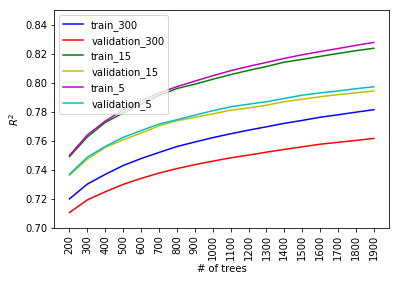

In [100]:
x = list(range(200,2000,100))
train_300, = plt.plot(x, r2_t_lr5, c = 'b', label = 'train_300')
val_300, = plt.plot(x, r2_v_lr5, c = 'r', label = 'validation_300')
train_15, = plt.plot(x, r2_t_lr4, c = 'g', label = 'train_15')
val_15, = plt.plot(x, r2_v_lr4, c = 'y', label = 'validation_15')
train, = plt.plot(x, r2_t_lr8, c = 'm', label = 'train_5')
val, = plt.plot(x, r2_v_lr8, c = 'c', label = 'validation_5')

plt.legend(handles=[train_300, val_300,train_15,val_15])

plt.xticks( x, rotation = 90)
plt.xlabel('# of trees')
plt.ylabel('$R^2$')
plt.legend()
plt.ylim(0.7,0.85 )